 # Задача определения "токсичных" комментариев

Требуется обучить модель классифицировать комментарии на позитивные и негативные. Качество модели должно оцениваться метрикой *F1*, и её значение не должно быть меньше 0.75.

В распоряжении набор данных с разметкой о токсичности комментариев. Столбец `text` содержит текст комментария, а `toxic` — оценка этих комментариев: 0 - позитивный, 1 - негативный (целевой класс).

<a id='section_1'></a>
## Подготовка

In [ ]:
!python -m pip install nltk pymystem3 tensorflow sentence_transformers

In [ ]:
# импорт основных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# импорт спец. библиотек
import os
import pickle
from random import random
import re
import nltk
import tensorflow as tf
from nltk.corpus import wordnet
from pymystem3 import Mystem
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

In [3]:
# импорт элементов библиотеки Scikit-Learn
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
# константы
FIG_SIZE = (7, 6)
RANDOM_STATE = 42

<a id='section_2'></a>
## Чтение и знакомство с данными

In [35]:
df = pd.read_csv("toxic_comments.csv")

------------- Исходные данные -------------


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



------ Техническая информация -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None
Дубликаты: 0
Типовые значения колонки 'toxic': [0 1] 



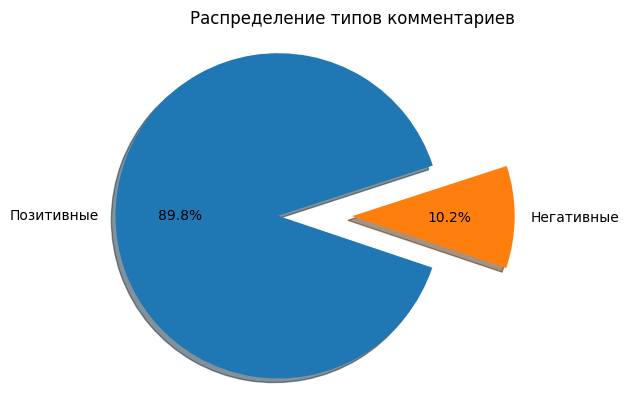

In [36]:
print('------------- Исходные данные -------------')
display(df.head())

print('\n------ Техническая информация -----')
print(df.info())
print("Дубликаты:", len(df[df.duplicated()]))
print("Типовые значения колонки 'toxic':", df['toxic'].unique(), '\n')

# распределение токсичности комментариев
plt.pie(df['toxic'].value_counts(),
        labels=['Позитивные', 'Негативные'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.5, 0),
        shadow=True,
        radius=1.10)
plt.title('Распределение типов комментариев');

**Итог:** Датасет содержит почти **160 тыс. комментариев**.
- Колонка `Unnamed: 0` вероятней всего содержала индексы, но в них присутствовали пропуски. По этой причине она была удалена.
- Присутствует дисбаланс классов: позитивных комментариев больше в 9 раз.
- Тип данных соответствует содержанию в колонка.
- Пропуски и дубликаты - отсутствуют.

**Кодирование текста.**
Задача модели, предсказывающей эмоциональный оттенок комментариев, будет разделена на две подзадачи:
- оцифровка текста;
- поиск закономерностей и оценка текста.

Каждая из этих задач будут реализованы отдельными спец. модель. В этом разделе будут разобраны несколько способов преобразования текста.

___

<a id='section_3'></a>
## TF-IDF (CPU)

Самый примитивны способ: использовать только слова встречаемые в исходном тексте.  Обучение и предсказание происходит только на словаре, который сформировывается из слов комментариев.

Оцифровка слов происходит за счёт подсчёта их важности, величиной TF-IDF. То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

_Примечание_: бóльшая величина TF-IDF говорит об уникальности слова в тексте по отношению к корпусу. Чем чаще оно встречается в конкретном тексте и реже в остальных, тем выше значение TF-IDF.

In [ ]:
# инициализация класса для лемматизации
WNLemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# функция определение части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция лемматизации и очистки текста
def lemm_clear_text(text):
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([WNLemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list])
    lemm_text = re.sub(r'[^ a-zA-Z]', '', lemm_text)
    lemm_text = lemm_text.split()
    lemm_clear_text =  ' '.join(lemm_text)
    return lemm_clear_text

Порядок работы функции лемматизации и очистки текста:
1. исходный текст
2. выделение слов и символов в самостоятельные объекты
3. лемматизация слов по отдельности
4. удаление посторонних символов и цифр
5. удаление лишних пробелов. (выделение оставшиеся слов в самостоятельные объекты)
6. финальное объединение слов в одно предложение

In [8]:
# лемматизация текста
tqdm.pandas()
df['lemm_text'] = df['text'].progress_apply(lemm_clear_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
from random import random
with open(f"lemmatized_df_{random()}.pcl", "wb") as f:
    pickle.dump(df, f)

In [38]:
with open(f"lemmatized_df_0.6588497349996866.pcl", "rb") as f:
    df = pickle.load(f)

In [39]:
# пример лемматизации текста
print('Исходный текст:', df.loc[1, 'text'])
print('Лемматизированный:', df.loc[1, 'lemm_text'])

Исходный текст: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Лемматизированный: Daww He match this background colour I m seemingly stuck with Thanks talk January UTC


После лемматизации теста появились пропуски. Это комментарии состоящие только из цифр и символов. Для них не существуют леммы, и следовательно результатом лемматизации будет: `NaN`. Пример этих объектов приведён ниже. В дальнейгей работе они использованы не будут.

In [40]:
print(df.info())
anomaly_index = df[(df['lemm_text'].isna()) | (df['lemm_text']=='')].index
display(df.loc[anomaly_index])
df.drop(index=anomaly_index, inplace=True)
df.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   lemm_text   159292 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB
None


,Unnamed: 0,text,toxic,lemm_text
4475,4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,
6289,6293,193.61.111.53 15:00,0,
10193,10206,"64.86.141.133""",0,
17280,17297,~ \n\n68.193.147.157,0,
38743,38792,"88.104.31.21""",0,
52336,52393,"14:53,",0,
53679,53740,92.24.199.233|92.24.199.233]],0,
61644,61711,"""\n\n 199.209.144.211 """,0,
82541,82619,"""\n '''''' 2010/2013 """,0,
119018,119123,"""""""",1,


In [ ]:
# скачивание стоп слов
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))

In [63]:
# подготовка обучающей выборки
target = df['toxic']
features = df['lemm_text']
RANDOM_STATE = 42

# выделение тренировочной выборки
X_train_tfidf, X_other, Y_train_tfidf, Y_other = train_test_split(features,
                                                                  target,
                                                                  stratify = target,
                                                                  train_size = 0.80,
                                                                  random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_tfidf, X_test_tfidf, Y_valid_tfidf, Y_test_tfidf = train_test_split(X_other,
                                                                            Y_other,
                                                                            stratify = Y_other,
                                                                            test_size = 0.50,
                                                                            random_state = RANDOM_STATE)

In [64]:
# "кодирование" текста
count_tf_idf.fit(X_train_tfidf)
X_train_tfidf = count_tf_idf.transform(X_train_tfidf)
X_valid_tfidf = count_tf_idf.transform(X_valid_tfidf)
X_test_tfidf  = count_tf_idf.transform(X_test_tfidf)

print('Количество признаков:', X_train_tfidf.shape[1])

Количество признаков: 2160914


Далее следует тестирование преобразованного текста. Поскольку в датасете присутствует дисбаланс, а целевая метрика _F1_ демонстрирует условную параллельность _Recall_ и _Precision_.
В дополнении к ней будет выводится значение этих метрик и применяться построение PR-кривой и значения порогов классификации.

Для оценки качества преобразования, закодированный текст сразу будет тестироваться на следующих моделях классификации:
- LogisticRegression;
- CatBoostClassifier.

<a id='section_3A'></a>
### LogisticRegression

In [31]:
# объявление модели Логистической регрессии и её гиперпараметров
LogRer_tfidf = LogisticRegression(C = 11.5,
                                  solver = 'sag',
                                  random_state = RANDOM_STATE)

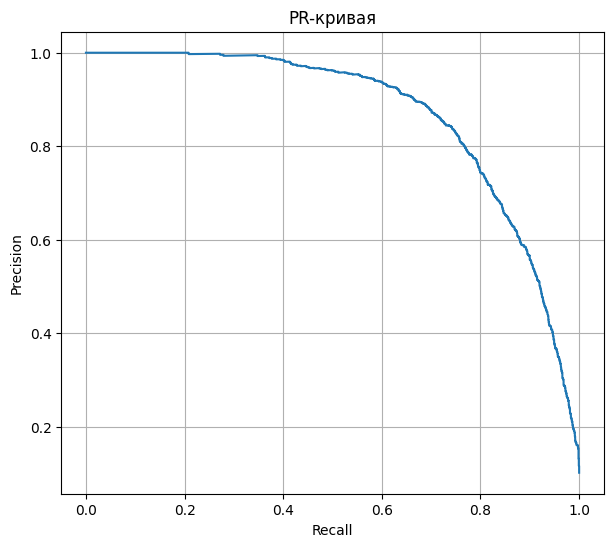

F1 = 0.778
Recall = 0.696
Precision = 0.881


In [41]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf.fit(X_train_tfidf, Y_train_tfidf)
prediction_valid = LogRer_tfidf.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

<a id='section_3B'></a>
### CatBoost

In [24]:
# модель градиентного бустинга CatBoost (CPU) 16 minutes
CatBoost_tfidf = CatBoostClassifier(verbose = 100, # шаг вывода информации о процессе обучения
                                    task_type = 'CPU', # среда работы модели
                                    max_depth = 3, # макс. глубина базовых моделей
                                    learning_rate = 0.9, # шаг градиентного бустинга
                                    eval_metric = 'F1') # метрика оценки модели

In [25]:
# обучение CatBoost на фичах TF-IDF
CatBoost_tfidf.fit(X_train_tfidf, Y_train_tfidf)

0:	learn: 0.4030562	total: 8.53s	remaining: 2h 21m 59s
100:	learn: 0.7792151	total: 9m 19s	remaining: 1h 22m 56s
200:	learn: 0.8085016	total: 18m 37s	remaining: 1h 14m 1s
300:	learn: 0.8261199	total: 27m 52s	remaining: 1h 4m 44s
400:	learn: 0.8440849	total: 37m 6s	remaining: 55m 25s
500:	learn: 0.8578056	total: 46m 13s	remaining: 46m 2s
600:	learn: 0.8693862	total: 55m 19s	remaining: 36m 43s
700:	learn: 0.8748666	total: 1h 4m 27s	remaining: 27m 29s
800:	learn: 0.8795013	total: 1h 13m 32s	remaining: 18m 16s
900:	learn: 0.8825914	total: 1h 22m 27s	remaining: 9m 3s
999:	learn: 0.8880173	total: 1h 31m 9s	remaining: 0us


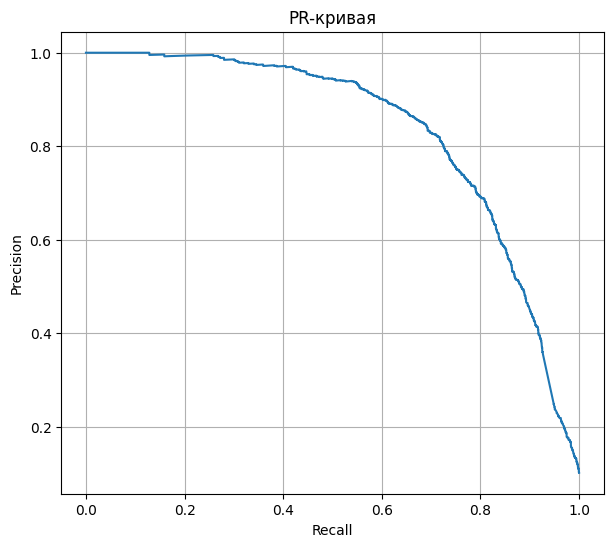

F1 = 0.762
Recall = 0.722
Precision = 0.807


In [26]:
# тестирование TF-IDF на CatBoost
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

**Итог:**
- Лемматизация текста занимает продолжительное время.
- Процесс векторизации подготовленного текста с помощью `TfidfVectorizer` - почти мгновенный. Слова, не имеющие смысловой нагрузки - удалены.
- Логистическая регрессия имеет значение целевой метрики F1 = 0.78
- Градиентный бустинг CatBoost F1 = 0.76, но время обучения на CPU 15 минут. Применение GPU требует большого объема ОП, что не позволяет его запустить на базовых мощностях [Google Colab](https://colab.research.google.com/).

Ключевым недостатком является большое количество признаков и объём памяти, которую они занимают. Это затрудняет использование GPU, к примеру для ускорения обучения модели CatBoost.

На данном этапе результат тестирования - приемлемый. Но необходимо учесть присутствующий дисбалланс классов. Этой теме будет посвящен отдельный раздел.

___

<a id='section_4'></a>
## Борьба с дисбалансом

<a id='section_5A'></a>
### Баланс классов

Использование встроенных средств модели, позволяющие стабилизировать разность между классами назначив им разные веса.

In [42]:
# объявление Логистической регрессии с балансом классов
LR_balanced = LogisticRegression(solver = 'sag',
                                 class_weight = 'balanced',
                                 random_state = RANDOM_STATE)

In [43]:
# тестирование TF-IDF на Logistic Regression + баланс классов
LR_balanced.fit(X_train_tfidf, Y_train_tfidf)
balanced_prediction_valid = LR_balanced.predict(X_valid_tfidf)

print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, balanced_prediction_valid)))

F1 = 0.742
Recall = 0.828
Precision = 0.673


Если ранее наблюдались заниженные значения полноты (Recall), то балансировка классов, за счёт изменения их веса, изменила положение на противоположное. Метрика F1 понизилась.

<a id='section_5B'></a>
### Изменение порога классификации

Поскольку в датасете присутствуют 2 класса, то по-умолчанию объекты распределяются либо в один класс либо в другой с вероятностью 50%.

Но в данной ситуации классы имеют разное соотношение друг к другу, а именно 1:9, не в пользу целевого класса (токсичные комментарии). В данном разделе будет смещаться порог классификации, ради повышения качества предсказания.

In [44]:
# тестирование TF-IDF на Logistic Regression + смещение порога классификации (2 minutes)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/15847 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.789, при смещении порога до значения 0.35


In [45]:
# CatBoost TF-IDF + смещение порога классификации (1 minutes)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/9131 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.765, при смещении порога до значения 0.53


Смещение порога классификации однозначно помогает учесть дисбаланс и повысить численность верно классифицированных объектов.

<a id='section_5C'></a>
### Уменьшение выборки (DownSampling)

Поскольку исходный  датасет содержит большое количество объектов (160 тыс.), есть возможность воспользоваться этим, чтобы уменьшить многочисленный класс и воссоздать баланс.

In [46]:
# деление признаков по классам
target_1   = Y_train_tfidf[Y_train_tfidf == 1]
target_0   = Y_train_tfidf[Y_train_tfidf == 0]
features_1 = df.loc[target_1.index, 'lemm_text']
features_0 = df.loc[target_0.index, 'lemm_text']

# уменьшение выборки многочисленного класса
Y_downsampled = pd.concat([target_0.sample(frac=(1/9),   random_state=RANDOM_STATE)] + [target_1])
X_downsampled = pd.concat([features_0.sample(frac=(1/9), random_state=RANDOM_STATE)] + [features_1])
X_downsampled = count_tf_idf.transform(X_downsampled)

In [47]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf_sd = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_tfidf_sd.fit(X_downsampled, Y_downsampled)
prediction_valid = LogRer_tfidf_sd.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf_sd.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

F1 = 0.664
Recall = 0.850
Precision = 0.544


In [48]:
# обучение CatBoost на ресемплированных фичах TF-IDF
CatBoost_tfidf_sd = CatBoostClassifier(verbose = 100, eval_metric = 'F1', early_stopping_rounds = 200)
CatBoost_tfidf_sd.fit(X_downsampled, Y_downsampled)

Learning rate set to 0.041186
0:	learn: 0.5481803	total: 8.36s	remaining: 2h 19m 6s
100:	learn: 0.7994419	total: 3m 57s	remaining: 35m 12s
200:	learn: 0.8373786	total: 7m 57s	remaining: 31m 38s
300:	learn: 0.8612570	total: 12m 2s	remaining: 27m 57s
400:	learn: 0.8777555	total: 16m 3s	remaining: 23m 59s
500:	learn: 0.8902121	total: 20m 2s	remaining: 19m 57s
600:	learn: 0.8992534	total: 24m 1s	remaining: 15m 56s
700:	learn: 0.9063062	total: 27m 58s	remaining: 11m 55s
800:	learn: 0.9116869	total: 31m 54s	remaining: 7m 55s
900:	learn: 0.9169976	total: 35m 48s	remaining: 3m 56s
999:	learn: 0.9222370	total: 39m 40s	remaining: 0us


In [52]:
# тестирование TF-IDF на CatBoost (CPU)
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

F1 = 0.762
Recall = 0.722
Precision = 0.807


Уменьшение выборки не позволило повысить значения рассматриваемых метрик, и фактически результат искусственный, поскольку игнорирует действительность.
___

<a id='section_6'></a>
## Итоговое тестирование

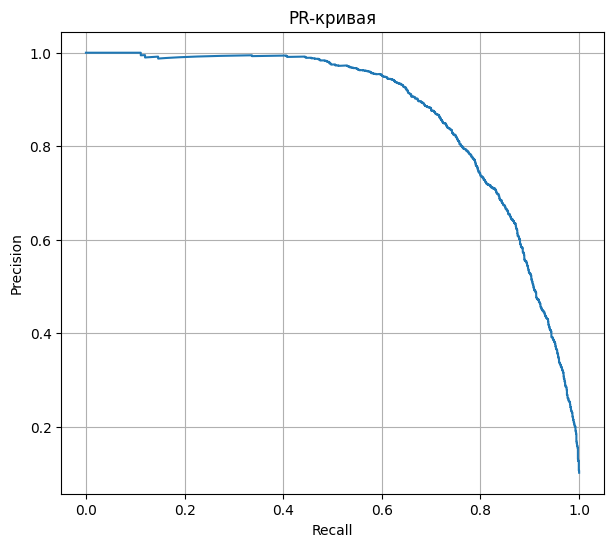

F1 = 0.782
Recall = 0.725
Precision = 0.849


In [77]:
# финальный тест TF-IDF на Logistic Regression + смещение порога классификации
proba_test = LogRer_tfidf.predict_proba(X_test_tfidf)
prediction_test_lr = proba_test[:, 1] > 0.4
precision, recall, thresholds = precision_recall_curve(Y_test_tfidf, proba_test[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test_lr)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test_lr)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test_lr)))

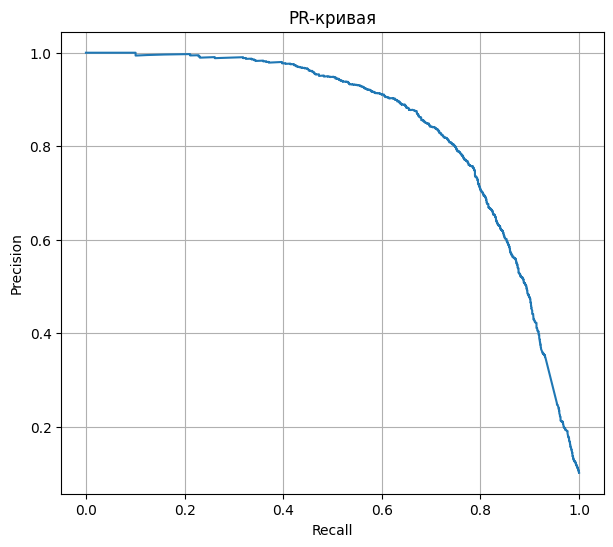

F1 = 0.773
Recall = 0.749
Precision = 0.798


In [71]:
# финальный тест TF-IDF на CatBoost + смещение порога классификации
proba_test = CatBoost_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.49
precision, recall, thresholds = precision_recall_curve(Y_test_tfidf, proba_test[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

## Обзор предсказанных значений

In [95]:
target = df['toxic']
features = df['lemm_text']
RANDOM_STATE = 42

# выделение тренировочной выборки
X_train, X, Y_train, Y = train_test_split(features,
                                          target,
                                          stratify = target,
                                          train_size = 0.80,
                                          random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid, X_test, Y_valid, Y_test = train_test_split(X_other,
                                                    Y_other,
                                                    stratify = Y_other,
                                                    test_size = 0.50,
                                                    random_state = RANDOM_STATE)



In [99]:
try:
    X_test.to_excel("features.xlsx")
    pd.DataFrame(prediction_test_lr).to_excel("prediction.xlsx")
except Exception as e:
    e
result_df = pd.read_excel("features.xlsx")

In [110]:
pd.options.display.max_colwidth = 100
result_df.sample(20)

,Unnamed: 0,lemm_text,0
13981,56032,There be no advertising go on It s listing service that of the school freshman and sophmores uti...,False
7217,97012,Hmm I remember the reason for the Magellan s visit differently Then again I may just have be con...,False
2773,91324,Almost forgot Here be a little something to identify you a a part of the Task Force You might wa...,False
10830,116309,I think we d need a cite for such usage be more establish than what From what I can tell the tra...,False
8489,35449,you stupid mother fucker dont you know this IP belongs to the great office depot This company ha...,True
10905,72366,Thanks Thanks very much for my very first award fritter You re very welcome enjoy,False
8781,84516,Speedy deletion decline Cruisest Hello Bazj I be just let you know that I decline the speedy del...,False
14145,1533,UTC Tennessee have not reapportion since rural district overrepresented urban district underrepr...,False
10393,9050,Being block So that s your idea of mediation be it R Lopez can run amok through Wikipedia with h...,True
238,81259,I attempt to contact you via Google Chat to discus Fred s edit but you be apparently busy fix th...,False


**Выводы**

Можно выделить основные критерии оценки модели:
- Время и ресурсы кодирование текста
- Время и ресурсы обучения модели
- Время предсказания
- Итоговое значение метрики

**Логистическая регрессия в кооперативе с TF-IDF векторизатором** являются наилучшим результатом (_F1 =  0.782_), поскольку обучение регрессии быстрое, предсказание - мгновенное. Для работы такой пары не требуется GPU в качестве аппаратного ускорителя. Итоговое значение метрики F1 выше у Логистической регрессии, и в добавок метрики более _сбалансированны_, если посмотреть на значения Recall и Precision.

Модель **CatBoost** может выдать предсказания более высшего качества, но для этого требуется более кропотливая настройка её гиперпараметров и дополнительное время работы. Процесс сильно зависим от технических мощностей компьютера/сервера.